In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2, os
import tensorflow as tf
from tensorflow.keras.applications import VGG16


In [ ]:
! mkdir -p /root/.kaggle
! mv kaggle.json /root/.kaggle
import kaggle

In [ ]:
!kaggle competitions download -c aerial-cactus-identification

 75% 9.00M/12.0M [00:00<00:00, 70.1MB/s]
100% 12.0M/12.0M [00:00<00:00, 83.9MB/s]


In [ ]:
! unzip -q aerial-cactus-identification.zip

In [ ]:
! rm -rvf test sample_submission.csv

removed 'sample_submission.csv'


In [ ]:
! unzip -q train.zip

In [ ]:
! unzip -q test.zip

In [ ]:
data = pd.read_csv("train.csv")

In [ ]:
data

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1
...,...,...
17495,ffede47a74e47a5930f81c0b6896479e.jpg,0
17496,ffef6382a50d23251d4bc05519c91037.jpg,1
17497,fff059ecc91b30be5745e8b81111dc7b.jpg,1
17498,fff43acb3b7a23edcc4ae937be2b7522.jpg,0


In [ ]:
batch_size=64
target_size = (224, 224)

In [ ]:
# base_model = VGG16(include_top=False, input_shape=(224,224, 3))


In [ ]:
# idg = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
#                                                       validation_split=0.1)

In [ ]:
# data['has_cactus'] = data['has_cactus'].astype(str)

In [ ]:
# train_idg = idg.flow_from_dataframe(data, "train", "id", "has_cactus", target_size = target_size,
#                                     batch_size = batch_size, subset = "training")

In [ ]:
# val_idg = idg.flow_from_dataframe(data, "train", "id", "has_cactus", target_size = target_size,
#                                     batch_size = batch_size, subset = "validation")

In [ ]:
data['has_cactus'] = data['has_cactus'].astype(str)


In [ ]:
idg = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0, validation_split=0.1)

In [ ]:
train_idg = idg.flow_from_dataframe(dataframe = data, directory = "train/",
                                    x_col="id", y_col="has_cactus",
                                    target_size=(300, 300),
                                    batch_size = batch_size,
                                    subset="training")

Found 15750 validated image filenames belonging to 2 classes.


In [ ]:
val_idg = idg.flow_from_dataframe(dataframe=data, directory = "train/",
                                  x_col = "id", y_col = "has_cactus",
                                  target_size=(300, 300),
                                  batch_size = batch_size,
                                  subset = "validation")

Found 1750 validated image filenames belonging to 2 classes.


In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input((300, 300, 3), name="InputLayer"))
# 1st chunk
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1),
                                 activation=tf.keras.activations.relu,
                                 padding='valid', name="Conv1"))
# (300 - 3 + 1)/ 1 = 298 | (298, 298, 32)
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2,2), name="Pool1"))
# (149, 149, 32)

# 2nd chunk
model.add (tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1),
                                  activation=tf.keras.activations.relu,
                                  padding="valid", name="Conv2"))
# (147, 147, 64)
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), name="Pool2", ))
# (73, 73, 64)

# 3rd Chunk
model.add (tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1),
                                  activation=tf.keras.activations.relu,
                                  padding="valid", name="Conv3"))
# (71, 71, 64)
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), name="Pool3"))
# (35, 35, 64)

model.add(tf.keras.layers.Flatten(name="Flat"))
model.add(tf.keras.layers.Dense(64, activation=tf.keras.activations.relu, name="Dense"))
model.add(tf.keras.layers.Dense(2, activation=tf.keras.activations.softmax, name="Output"))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 298, 298, 32)      896       
                                                                 
 Pool1 (MaxPooling2D)        (None, 149, 149, 32)      0         
                                                                 
 Conv2 (Conv2D)              (None, 147, 147, 64)      18496     
                                                                 
 Pool2 (MaxPooling2D)        (None, 73, 73, 64)        0         
                                                                 
 Conv3 (Conv2D)              (None, 71, 71, 64)        36928     
                                                                 
 Pool3 (MaxPooling2D)        (None, 35, 35, 64)        0         
                                                                 
 Flat (Flatten)              (None, 78400)            

In [ ]:
del model

In [ ]:
 model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=["acc"])

In [ ]:
model.fit(train_idg,batch_size=batch_size, epochs=10, validation_data=val_idg)


Epoch 1/10
247/247 [==============================] - 59s 230ms/step - loss: 0.5019 - acc: 0.7533 - val_loss: 0.4413 - val_acc: 0.7394
Epoch 2/10
247/247 [==============================] - 56s 225ms/step - loss: 0.3722 - acc: 0.8221 - val_loss: 0.2441 - val_acc: 0.9131
Epoch 3/10
247/247 [==============================] - 55s 224ms/step - loss: 0.2298 - acc: 0.9134 - val_loss: 0.2095 - val_acc: 0.9149
Epoch 4/10
247/247 [==============================] - 55s 222ms/step - loss: 0.1809 - acc: 0.9344 - val_loss: 0.1442 - val_acc: 0.9514
Epoch 5/10
247/247 [==============================] - 56s 224ms/step - loss: 0.1974 - acc: 0.9326 - val_loss: 0.1659 - val_acc: 0.9371
Epoch 6/10
247/247 [==============================] - 57s 228ms/step - loss: 0.1497 - acc: 0.9453 - val_loss: 0.1473 - val_acc: 0.9474
Epoch 7/10
247/247 [==============================] - 55s 222ms/step - loss: 0.1363 - acc: 0.9518 - val_loss: 0.1199 - val_acc: 0.9629
Epoch 8/10
247/247 [==============================] - 5

Text(0.5, 1.0, 'Accuracy of Model')

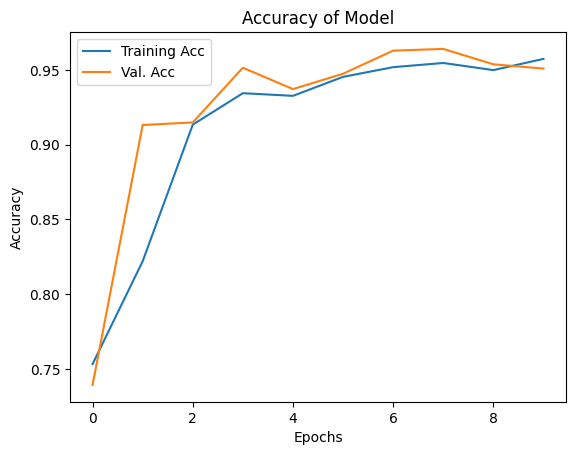

In [ ]:
plt.plot(model.history.history["acc"], label = "Training Acc")
plt.plot(model.history.history["val_acc"], label = "Val. Acc")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy of Model")